In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


In [2]:
sns.set_style("whitegrid", 
              {'patch.edgecolor': 'k'})

In [3]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [ ]:
# We'll use this dataframe later for lookup
title_df.head()

In [ ]:
genres_item_matrix.head()

In [ ]:
tag_item_matrix.head()

In [4]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.tail()

In [ ]:
df.info()

In [ ]:
df.describe()

In [5]:
total_per_feature = df.sum(axis=0)
total_per_feature

action       2635
adventure    2097
comedy       3846
drama        1875
ecchi         614
             ... 
yakuza         34
yandere        45
youkai        109
yuri          250
zombie         53
Length: 265, dtype: int64

In [6]:
total_per_show = df.sum(axis=1)
total_per_show

id
10161      9
99726     13
98526      5
966        9
4876      11
          ..
99586     11
99916      7
101283    18
101633    12
101089     3
Length: 9832, dtype: int64

In [ ]:
total_per_show.rename('total_features_per_show')

In [ ]:
fig, ax = plt.subplots(2,1, 
                       figsize=(8,4),
                       sharex=True, 
                       gridspec_kw={'height_ratios': [2, 1]})
ax[0].hist(total_per_show, 
           bins=35, 
           color='cornflowerblue')
ax[0].set_title('Anime and Genre/Tags')
ax[0].set_ylabel('Anime Count')
ax[1] = sns.boxplot(total_per_show, 
                    color='cornflowerblue')
ax[1].set_xlabel('Number of Features')

fig.tight_layout();

# plt.savefig('images/anime_feature_counts.png', 
#             dpi=150, 
#             format='png')

This seems potentially problematic. A majority of the shows don't have very many features. How many are needed to make an acurate recommendation?

In [ ]:
def count_for_n_features(series, n):
    print('{0:.1%}'.format(len(series[series <= n]) / len(series)), 
          'or', len(series[series <= n]), f'shows have {n} or fewer features describing them.')


In [ ]:
count_for_n_features(total_per_show, 2)

In [ ]:
count_for_n_features(total_per_show, 3)

In [ ]:
count_for_n_features(total_per_show, 4)

While selecting which tags to keep, many were cut out because of a low "rank" score. Let's go back and keep all tags but normalize(standardize?) them. 

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].hist(total_per_show, bins=30)
ax[1] = sns.boxplot(total_per_feature);

In [ ]:
# the tags below each describe 5 or fewer anime. They can be dropped without losing too much.
total_per_feature[total_per_feature < 6]

## Getting Recommendations

In [ ]:
def jaccard_similarity(df):
    return (1 - pairwise_distances(df, metric="jaccard"))


def get_anime_id(search_term):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([search_term])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


def view_title_similarity(search_term, recom_titles):
    for title in recom_titles:
        seq_matcher = SequenceMatcher(None, search_term, title)
        print(f'The terms "{search_term}" and "{title}" are ' 
              + '{0:.2%}'.format(seq_matcher.quick_ratio()) + ' alike.')

In [ ]:
cos_sim = cosine_similarity(df.values)

jac_sim = jaccard_similarity(df.values)

In [ ]:
def get_search_term(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title

<b>Recommendations should probably exclude titles from the same franchise.  
For example, try getting recommendations for Ghost in the Shell.  
If you already know you like Ghost in the Shell, it's pretty easy to find others in the same franchise if that's what you want.  </b>

First of all, our rudimentary search engine is failing...

In [ ]:
initial_search = 'Ghost in the Shell'
search_term = get_search_term(initial_search)
search_term

In [ ]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

In [ ]:
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)
search_term

In [ ]:
id_list = get_anime_id(search_term)
id_list

In [ ]:
n=5
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=n)
print('-----')
print(f'Top {n} based on {search_term}: \n{rec_list}')

In [ ]:
view_title_similarity(search_term, rec_list)

Why is a Pokemon movie showing up as a recommendation based on Wolf's Rain? Also, why is Wan Wan Chuushingur being recommended. More on that one later. 

## Understanding Bad Recommendations

<tr>
    <td> <img src="https://upload.wikimedia.org/wikipedia/en/thumb/4/43/Wolf%27s_Rain_Region_2_Volume_1.jpg/220px-Wolf%27s_Rain_Region_2_Volume_1.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/95/Pok%C3%A9mon_Lucario_film_poster.jpg/220px-Pok%C3%A9mon_Lucario_film_poster.jpg" alt="Drawing" style="width: 250px;"/> </td>
    </tr>

In [ ]:
wr_id = title_df[title_df['english'] == "Wolf's Rain"].index
wr_df = df.loc[wr_id,:]

In [ ]:
# Genres and tags for Wolf's Rain
wr_df.loc[:, (wr_df != 0).any(axis=0)]

In [ ]:
pk_id = title_df[title_df['english'] == "Pokémon: Lucario and the Mystery of Mew"].index
pk_df = df.loc[pk_id,:]

In [ ]:
# Genres and tags for Pokémon: Lucario and the Mystery of Mew
pk_df.loc[:, (pk_df != 0).any(axis=0)]

Would it be wise to give a heavier weight to the "kids" column?

In [ ]:
sum(df['kids'])

In [ ]:
total_per_feature['kids']

In [ ]:
len(df)

In [ ]:
plt.bar(['Kids', 'Not Kids'], [total_per_feature['kids'], len(df) - total_per_feature['kids']]);

In [ ]:
plt.hist(total_per_feature, bins=50)
plt.ylabel('Number of Tags')
plt.xlabel('Total Number of Shows Per Tag');

In [ ]:
for tag, count in total_per_feature.sort_values(ascending=False).iteritems():
    print(tag, count)

<b>Would like to penalize features that describe a large number of shows (i.e. comedy) and give a heavier weight to those that describe fewer shows.  
The normalization should be strong enough to not recommend a Pokemon movie when looking at "Wolf's Rain" but not so strong that all recommendations are based on the rarest tag. </b>

In [ ]:
initial_search = 'Ghost in the Shell'
search_term = get_search_term(initial_search)
search_term

In [ ]:
# using cosine similarity 
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

<b> The search is working but maybe we're returning too many from the same franchise.</b>

In [ ]:
view_title_similarity('Ghost in the Shell', rec_list)

In [ ]:
seq_matcher = SequenceMatcher(None, 
                              "Ghost in the Shell Arise: Alternative Architecture", 
                              "Ghost in the Shell: Stand Alone Complex 2nd GIG")
seq_matcher.quick_ratio()

This is one problem with the recommender. The recommendations are good but too many are not very useful for a user. Future work on the project would include going through and filtering out titles from the same franchise or only including one title per franchise. 

In [ ]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=25)
rec_list

In [ ]:
## top 10 while limiting 1 per franchise
['Appleseed',
 'New Cutey Honey',
 'Armitage III',
 'Fireball Charming',
 'Jin-Roh: The Wolf Brigade',
 'Ergo Proxy',
 'The Animatrix',
 'Mardock Scramble: The Second Combustion',
 'Harmony',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

## Comparing Cosine Similarity and Jaccard

We can do Jaccard because our data is still binary

### Samurai Champloo

In [ ]:
initial_search = 'Samurai Champloo'
search_term = get_search_term(initial_search)
search_term

In [ ]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

In [ ]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, jac_sim, n=10)
rec_list

Cosine similarity and jaccard similarity are returning similar results.

In [ ]:
def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]
    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)

In [ ]:
champloo_tags = view_features(get_search_term('Samurai Champloo'), df)
champloo_tags

In [ ]:
# Blade of the Immortal scored higher with cosine similarity than jaccard similarity
blade_immortal_tags = view_features(get_search_term("Blade of the Immortal"), df)
blade_immortal_tags

In [ ]:
# "Ranma ½: One Flew Over the Kuno's Nest" scored higher with jaccard similarity than cosine similarity
ranma_tags = view_features(get_search_term("Ranma ½: One Flew Over the Kuno's Nest"), df)
ranma_tags

Both have a "supernatural" tag while "Samurai Champloo" does not.  
"Action" and "Adventure" are present for all three.  
"Blade of the Immortal" shares "historical", "samurai", and "swordplay"  
"Ranma ½: One Flew Over the Kuno's Nest" shares "comedy", "martial_arts", and "shounen".

In [ ]:
temp_categories = total_per_feature[total_per_feature.index.isin(['action', 
                                                                  'adventure', 
                                                                  'supernatural', 
                                                                  'historical', 
                                                                  'samurai', 
                                                                  'swordplay', 
                                                                  'comedy', 
                                                                  'martial_arts', 
                                                                  'shounen'])]
plt.bar(temp_categories.index, temp_categories)
plt.title('Number of Shows Per Genre/Tag');

Not sure what's going on but it appears jaccard similarity may be favoring more common features.  
To Be Continued...

## Diving into EDA

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax[0].hist(total_per_feature, 
           bins=100, color='cornflowerblue')
ax[0].set_title('Number of Shows Per Genre/Tag')
ax[0].set_ylabel('Tag Count')

ax[1].boxplot(total_per_feature, vert=False)
ax[1].set_xlabel('Anime Count');

# plt.savefig('images/anime_feature_counts.png', 
#             dpi=96, 
#             format='png', 
#             transparent=True);

### Genres

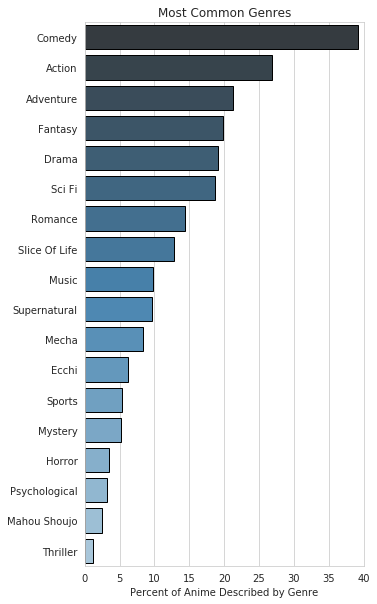

In [19]:
sorted_genres = genres_item_matrix.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot([((x/len(df)) * 100) for x in sorted_genres], 
                 [(x.replace('_', ' ')).title() for x in sorted_genres.index], 
                 orient='h', 
                 palette='Blues_d')
ax.set(xlim=(0,40))
ax.set_title('Most Common Genres')
ax.set_xlabel('Percent of Anime Described by Genre')

plt.savefig('images/common_genres.png', 
            dpi=96, 
            format='png', 
            bbox_inches='tight');

<b>Slice of Life</b> - depiction of everyday life experiences of (usually) ordinary people

<b>Mecha</b> - giant robots

<b>Ecchi</b> - defined by Wikipedia as "an often used slang term in the Japanese language for playfully sexual actions"

<b>Mahou Shoujo</b> - magical girl


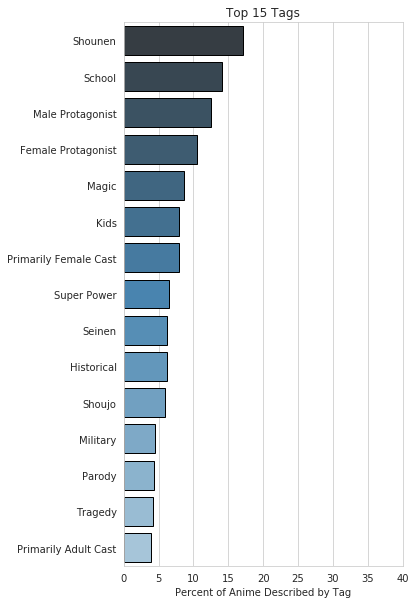

In [17]:
sorted_tags = tag_item_matrix.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(5, 10))
count=15
ax = sns.barplot([((x/len(df)) * 100) for x in sorted_tags[:count]], 
                 [(x.replace('_', ' ')).title() for x in sorted_tags.index[:count]], 
                 orient='h', 
                 palette='Blues_d')
ax.set(xlim=(0,40))
ax.set_title(f'Top {count} Tags')
ax.set_xlabel('Percent of Anime Described by Tag')

plt.savefig('images/common_tags.png', 
            dpi=96, 
            format='png', 
            bbox_inches='tight');

<b>Shounen</b> - manga and anime marketed towards teenage males. 

<b>Seinen</b> - manga and anime marketed towards young adult men.

<b>Shoujo</b> - manga and anime marketed towards teenage females.

## Weighing Features

In [ ]:
tag_rank_item_matrix.head()

In [ ]:
df_w_rank = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
df_w_rank.head()

In [ ]:
df_w_rank.tail()

In [ ]:
cos_sim_rank = cosine_similarity(df_w_rank.values)

In [ ]:
cos_sim_rank

In [ ]:
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=5)


In [ ]:
# boolean matrix
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)

id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

In [ ]:
# Accounting for tag relevance to title
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)

id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df_w_rank, cos_sim_rank, n=10)
rec_list

<b>Using rank pushed the Pokemon recommendation back. That's a good sign.</b>  
'Wan Wan Chuushingura' is still present through. Why?

In [ ]:
view_features(get_search_term("Wolf's Rain"), df_w_rank)

In [ ]:
view_features(get_search_term('Wan Wan Chuushingura'), df_w_rank)

All of the tags for "Wan Wan Chuushingura" are also tags for "Wolf's Rain" but there are a few missing that are very important. This goes back to a problem noticed earlier. Our data is more sparce than what is ideal. We need more tags for "Wan Wan Chuushingura" for our recommender to see that maybe this isn't a great suggestion based on Wolf's Rain.  
Would it be worth penalizing titles with fewer features?  
Or maybe we just cut out titles with fewer features? 

### Penalization Vectors

In [ ]:
score_df = pd.read_csv('data/score_df.csv', index_col='id')

In [ ]:
score_df.head()

In [ ]:
sns.scatterplot(score_df['averageScore'], 
                score_df['popularity'], 
                s=30, 
                alpha=.5);

In [ ]:
# popular yet poorly rated
x = score_df[(score_df['averageScore'] < 30) & (score_df['popularity'] > 15000)]

get_title_from_id(x.index.values[0])

In [ ]:
top_10_pop = list(score_df['popularity'].sort_values()[-10:].index)
top_10_pop

In [ ]:
top_10_score = list(score_df['averageScore'].sort_values().dropna()[-10:].index)
top_10_score

In [ ]:
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title

In [ ]:
for _id in top_10_pop:
    print(get_title_from_id(_id))

In [ ]:
for _id in top_10_score:
    print(get_title_from_id(_id))

To confirm, popularity is not based on averageScore

In [ ]:
score_df['popularity'].sort_values().index

In [ ]:
sorted_pop = score_df['popularity'].sort_values()
for num, idx_pop in enumerate(sorted_pop.items()):
    score_df.loc[idx_pop[0], 'pop_rank'] = num


In [ ]:
score_df

In [ ]:
for _id in list(score_df['pop_rank'].sort_values()[-10:].index):
    print(get_title_from_id(_id))


In [ ]:
scaler = MinMaxScaler()
scaled_pop = scaler.fit_transform(score_df['popularity'].to_numpy().reshape(-1, 1))

In [ ]:
for _id in list(score_df['pop_scaled'].sort_values()[-10:].index):
    print(_id, get_title_from_id(_id))


In [ ]:
score_df.head()

In [ ]:
sns.scatterplot(score_df['averageScore'], 
                score_df['pop_rank'], 
                s=30, 
                alpha=.5);

In [ ]:
score_df['score_scaled'] = score_df['averageScore'] / 100

In [ ]:
score_df

In [ ]:
score_df['pop_scaled'].sort_values()

In [ ]:
a = .1
score_df['adjusted_score'] = ((a * score_df['pop_scaled']) + .9) * score_df['score_scaled']

In [ ]:
score_df = score_df.fillna(value=0)

In [ ]:
top_15_df = score_df.sort_values(by='adjusted_score').tail(15)
top_15_df

In [ ]:
title_df.loc[list(top_15_df.index.values),:]

In [ ]:
# score_df[['pop_scaled', 'score_scaled', 'adjusted_score']].to_csv('data/adjusted_score_df.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
sns.scatterplot(y='pop_scaled', 
                x= 'score_scaled',
                data=score_df,
                s=30, 
                hue='adjusted_score')
ax.set_ylabel('Scaled Popularity')
ax.set_xlabel('Scaled Score');

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x= 'adjusted_score',
                y= 'score_scaled',
                data=score_df,
                s=30, 
                hue='pop_scaled')
ax.set_xlabel('Adjusted Score')
ax.set_ylabel('Scaled Score');